In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import xml.etree.ElementTree as ET
import torch
from ultralytics import YOLO
from numba import cuda
from PIL import Image

In [2]:
def extractCoordinates(filepath):
    tree = ET.parse(filepath)
    root = tree.getroot()
    cObject = root.find("object")
    box = cObject.find("bndbox")
    x_min = box.find("xmin").text
    x_max = box.find("xmax").text
    y_min = box.find("ymin").text
    y_max = box.find("ymax").text
    return [int(x_min), int(x_max), int(y_min), int(y_max)]

cdr = extractCoordinates("Dataset/annotations/Cars0.xml")


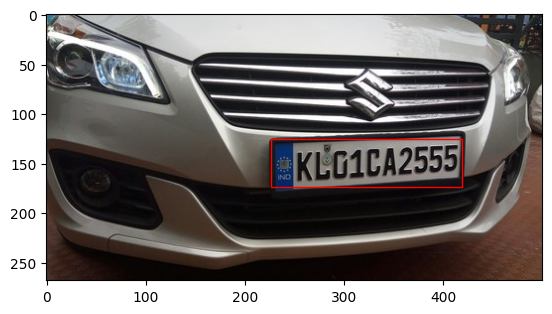

In [3]:
def plotBoundingBox(pos, filePath):
    img = mpimg.imread(filePath)
    imgplot = plt.imshow(img)
    ax = plt.subplot()
    rect = patches.Rectangle((pos[0], pos[2]), pos[1]-pos[0], pos[3]-pos[2], linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    plt.show()
plotBoundingBox(cdr, "Dataset/images/Cars" + '0' + ".png")

In [4]:
def writeLabels(pos, carNum, outputFile):
    f = open(outputFile+ f'/labels/Cars{carNum}.txt', 'w')
    pos = convertToYOLOFormat(pos)
    f.write(f"0 {pos[0]} {pos[1]} {pos[2]} {pos[3]}")
    f.close

def convertToYOLOFormat(pos):
    a = [0,0,0,0]
    a[0] = (pos[0] + pos[1])/(2*640)
    a[1] = (pos[2]+pos[3])/(2*640)
    a[2] = (pos[1]-pos[0])/(640)
    a[3] = (pos[3]- pos[2])/(640)
    
    return a
    

In [5]:
def resizeBoundingBoxes(carNum, size):
    pos = extractCoordinates(f"Dataset/annotations/Cars{carNum}.xml")
    Rx = 640/size[0]
    Ry = 640/size[1]
    return [Rx*pos[0], Rx*pos[1], Ry*pos[2], Ry*pos[3]]

def resizeImage(carNum, outputFile):
    im = Image.open(f"Dataset/images/Cars{carNum}.png")
    size = im.size
    pos = resizeBoundingBoxes(carNum, size)
    writeLabels(pos, carNum, outputFile)
    im=im.resize((640,640), resample=Image.NEAREST)
    im.save(outputFile+ f"/images/Cars{carNum}.png")
    
    #plotBoundingBox(pos, f"Dataset/new_images/Cars{carNum}.png")


In [172]:
for num in range(216):
    resizeImage(num, "train")

In [173]:
for num in range(217, 433):
    resizeImage(num, "valid")

In [174]:
# Check for CUDA device and set it
device = 'cuda' if torch.cuda.is_available() else 'mps'
print(f'Using device: {device}')
#cuda.select_device(2)
# Load model
model = YOLO('yolov8n.pt').to(device)

Using device: mps


In [175]:
model.train(data="licenseplate.yaml", epochs=10, imgsz=640, batch=12)
metrics = model.val()
print(metrics)

New https://pypi.org/project/ultralytics/8.0.230 available 😃 Update with 'pip install -U ultralytics'
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=licenseplate.yaml, epochs=10, time=None, patience=50, batch=12, imgsz=640, save=True, save_period=-1, cache=False, device=mps:0, workers=8, project=None, name=train23, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True,

train: Scanning /Users/ashwinbardhwaj/Documents/08_Personal Projects/License Plate Detector/train/labels... 217 images, 0 backgrounds, 0 corrupt: 100%|██████████| 217/217 [00:00<00:00, 2991.79it/s]

train: New cache created: /Users/ashwinbardhwaj/Documents/08_Personal Projects/License Plate Detector/train/labels.cache



val: Scanning /Users/ashwinbardhwaj/Documents/08_Personal Projects/License Plate Detector/valid/labels... 216 images, 0 backgrounds, 0 corrupt: 100%|██████████| 216/216 [00:00<00:00, 3275.51it/s]

val: New cache created: /Users/ashwinbardhwaj/Documents/08_Personal Projects/License Plate Detector/valid/labels.cache
Plotting labels to runs/detect/train23/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.00046875), 63 bias(decay=0.0)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/nn/functional.py:2443: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if size_prods == 1:


10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10         0G      1.516      3.604      1.437          1        640: 100%|██████████| 19/19 [01:35<00:00,  5.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/9 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 1.700s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  11%|█         | 1/9 [00:08<01:05,  8.16s/it]

WARNING ⚠️ NMS time limit 1.700s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  22%|██▏       | 2/9 [00:14<00:51,  7.34s/it]

WARNING ⚠️ NMS time limit 1.700s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  33%|███▎      | 3/9 [00:20<00:39,  6.54s/it]

WARNING ⚠️ NMS time limit 1.700s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  44%|████▍     | 4/9 [00:26<00:30,  6.14s/it]

WARNING ⚠️ NMS time limit 1.700s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  56%|█████▌    | 5/9 [00:32<00:25,  6.36s/it]

WARNING ⚠️ NMS time limit 1.700s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  67%|██████▋   | 6/9 [00:39<00:19,  6.43s/it]

WARNING ⚠️ NMS time limit 1.700s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  78%|███████▊  | 7/9 [00:46<00:13,  6.73s/it]

WARNING ⚠️ NMS time limit 1.700s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  89%|████████▉ | 8/9 [00:54<00:07,  7.06s/it]

WARNING ⚠️ NMS time limit 1.700s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [01:02<00:00,  6.91s/it]


                   all        216        216    0.00306     0.0509     0.0307     0.0171

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10         0G      1.561      2.914      1.383          1        640: 100%|██████████| 19/19 [01:05<00:00,  3.44s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/9 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 1.700s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  11%|█         | 1/9 [00:03<00:26,  3.33s/it]

WARNING ⚠️ NMS time limit 1.700s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  22%|██▏       | 2/9 [00:06<00:23,  3.38s/it]

WARNING ⚠️ NMS time limit 1.700s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  33%|███▎      | 3/9 [00:10<00:20,  3.48s/it]

WARNING ⚠️ NMS time limit 1.700s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  44%|████▍     | 4/9 [00:13<00:17,  3.42s/it]

WARNING ⚠️ NMS time limit 1.700s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  56%|█████▌    | 5/9 [00:17<00:13,  3.40s/it]

WARNING ⚠️ NMS time limit 1.700s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  67%|██████▋   | 6/9 [00:20<00:10,  3.37s/it]

WARNING ⚠️ NMS time limit 1.700s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  78%|███████▊  | 7/9 [00:23<00:06,  3.35s/it]

WARNING ⚠️ NMS time limit 1.700s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  89%|████████▉ | 8/9 [00:27<00:03,  3.41s/it]

WARNING ⚠️ NMS time limit 1.700s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:30<00:00,  3.40s/it]


                   all        216        216       0.41     0.0509     0.0475     0.0258

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10         0G      1.445      2.593      1.335          1        640: 100%|██████████| 19/19 [00:56<00:00,  2.99s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/9 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 1.700s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  11%|█         | 1/9 [00:03<00:30,  3.79s/it]

WARNING ⚠️ NMS time limit 1.700s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  22%|██▏       | 2/9 [00:07<00:24,  3.57s/it]

WARNING ⚠️ NMS time limit 1.700s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  33%|███▎      | 3/9 [00:10<00:20,  3.49s/it]

WARNING ⚠️ NMS time limit 1.700s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  44%|████▍     | 4/9 [00:14<00:17,  3.47s/it]

WARNING ⚠️ NMS time limit 1.700s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  56%|█████▌    | 5/9 [00:17<00:13,  3.46s/it]

WARNING ⚠️ NMS time limit 1.700s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  67%|██████▋   | 6/9 [00:21<00:10,  3.54s/it]

WARNING ⚠️ NMS time limit 1.700s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  78%|███████▊  | 7/9 [00:26<00:08,  4.03s/it]

WARNING ⚠️ NMS time limit 1.700s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  89%|████████▉ | 8/9 [00:31<00:04,  4.54s/it]

WARNING ⚠️ NMS time limit 1.700s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:36<00:00,  4.01s/it]


                   all        216        216      0.688     0.0185     0.0246     0.0172

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10         0G      1.551      2.456      1.348          1        640: 100%|██████████| 19/19 [01:00<00:00,  3.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/9 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 1.700s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  11%|█         | 1/9 [00:03<00:31,  3.90s/it]

WARNING ⚠️ NMS time limit 1.700s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  22%|██▏       | 2/9 [00:07<00:25,  3.64s/it]

WARNING ⚠️ NMS time limit 1.700s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  33%|███▎      | 3/9 [00:10<00:21,  3.55s/it]

WARNING ⚠️ NMS time limit 1.700s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  44%|████▍     | 4/9 [00:14<00:17,  3.42s/it]

WARNING ⚠️ NMS time limit 1.700s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  56%|█████▌    | 5/9 [00:17<00:13,  3.47s/it]

WARNING ⚠️ NMS time limit 1.700s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  67%|██████▋   | 6/9 [00:21<00:10,  3.48s/it]

WARNING ⚠️ NMS time limit 1.700s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  78%|███████▊  | 7/9 [00:24<00:06,  3.48s/it]

WARNING ⚠️ NMS time limit 1.700s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  89%|████████▉ | 8/9 [00:28<00:03,  3.50s/it]

WARNING ⚠️ NMS time limit 1.700s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:31<00:00,  3.52s/it]


                   all        216        216      0.391      0.037     0.0309    0.00962

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10         0G      1.491      2.337      1.299          1        640: 100%|██████████| 19/19 [01:16<00:00,  4.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/9 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 1.700s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  11%|█         | 1/9 [00:05<00:42,  5.27s/it]

WARNING ⚠️ NMS time limit 1.700s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  22%|██▏       | 2/9 [00:08<00:29,  4.27s/it]

WARNING ⚠️ NMS time limit 1.700s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  33%|███▎      | 3/9 [00:12<00:23,  3.99s/it]

WARNING ⚠️ NMS time limit 1.700s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  44%|████▍     | 4/9 [00:16<00:19,  3.81s/it]

WARNING ⚠️ NMS time limit 1.700s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  56%|█████▌    | 5/9 [00:19<00:15,  3.76s/it]

WARNING ⚠️ NMS time limit 1.700s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  67%|██████▋   | 6/9 [00:23<00:11,  3.68s/it]

WARNING ⚠️ NMS time limit 1.700s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  78%|███████▊  | 7/9 [00:26<00:07,  3.59s/it]

WARNING ⚠️ NMS time limit 1.700s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  89%|████████▉ | 8/9 [00:30<00:03,  3.55s/it]

WARNING ⚠️ NMS time limit 1.700s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:33<00:00,  3.73s/it]


                   all        216        216      0.144     0.0278     0.0173     0.0072

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10         0G      1.561      2.282      1.371          1        640: 100%|██████████| 19/19 [00:57<00:00,  3.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/9 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 1.700s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  11%|█         | 1/9 [00:04<00:34,  4.31s/it]

WARNING ⚠️ NMS time limit 1.700s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  22%|██▏       | 2/9 [00:07<00:26,  3.85s/it]

WARNING ⚠️ NMS time limit 1.700s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  33%|███▎      | 3/9 [00:11<00:22,  3.67s/it]

WARNING ⚠️ NMS time limit 1.700s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  44%|████▍     | 4/9 [00:14<00:18,  3.65s/it]

WARNING ⚠️ NMS time limit 1.700s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  56%|█████▌    | 5/9 [00:18<00:14,  3.59s/it]

WARNING ⚠️ NMS time limit 1.700s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  67%|██████▋   | 6/9 [00:21<00:10,  3.55s/it]

WARNING ⚠️ NMS time limit 1.700s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  78%|███████▊  | 7/9 [00:25<00:07,  3.55s/it]

WARNING ⚠️ NMS time limit 1.700s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  89%|████████▉ | 8/9 [00:29<00:03,  3.79s/it]

WARNING ⚠️ NMS time limit 1.700s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:34<00:00,  3.80s/it]

                   all        216        216      0.729     0.0324     0.0328     0.0186



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10         0G      1.377      2.121      1.346          1        640: 100%|██████████| 19/19 [01:06<00:00,  3.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/9 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 1.700s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  11%|█         | 1/9 [00:04<00:38,  4.76s/it]

WARNING ⚠️ NMS time limit 1.700s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  22%|██▏       | 2/9 [00:08<00:30,  4.31s/it]

WARNING ⚠️ NMS time limit 1.700s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  33%|███▎      | 3/9 [00:12<00:23,  3.94s/it]

WARNING ⚠️ NMS time limit 1.700s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  44%|████▍     | 4/9 [00:15<00:18,  3.79s/it]

WARNING ⚠️ NMS time limit 1.700s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  56%|█████▌    | 5/9 [00:19<00:14,  3.69s/it]

WARNING ⚠️ NMS time limit 1.700s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  67%|██████▋   | 6/9 [00:23<00:11,  3.89s/it]

WARNING ⚠️ NMS time limit 1.700s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  78%|███████▊  | 7/9 [00:27<00:07,  3.83s/it]

WARNING ⚠️ NMS time limit 1.700s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  89%|████████▉ | 8/9 [00:31<00:03,  4.00s/it]

WARNING ⚠️ NMS time limit 1.700s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:35<00:00,  3.95s/it]


                   all        216        216      0.391     0.0556     0.0579      0.035

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10         0G      1.412      2.101      1.257          1        640: 100%|██████████| 19/19 [01:00<00:00,  3.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/9 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 1.700s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  11%|█         | 1/9 [00:03<00:31,  3.89s/it]

WARNING ⚠️ NMS time limit 1.700s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  22%|██▏       | 2/9 [00:07<00:25,  3.67s/it]

WARNING ⚠️ NMS time limit 1.700s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  33%|███▎      | 3/9 [00:12<00:25,  4.30s/it]

WARNING ⚠️ NMS time limit 1.700s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  44%|████▍     | 4/9 [00:17<00:22,  4.47s/it]

WARNING ⚠️ NMS time limit 1.700s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  56%|█████▌    | 5/9 [00:20<00:16,  4.13s/it]

WARNING ⚠️ NMS time limit 1.700s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  67%|██████▋   | 6/9 [00:24<00:12,  4.04s/it]

WARNING ⚠️ NMS time limit 1.700s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  78%|███████▊  | 7/9 [00:28<00:07,  3.89s/it]

WARNING ⚠️ NMS time limit 1.700s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  89%|████████▉ | 8/9 [00:31<00:03,  3.79s/it]

WARNING ⚠️ NMS time limit 1.700s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:35<00:00,  3.94s/it]

                   all        216        216      0.733     0.0463     0.0487     0.0264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10         0G      1.321      1.831      1.168          1        640: 100%|██████████| 19/19 [01:04<00:00,  3.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/9 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 1.700s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  11%|█         | 1/9 [00:04<00:34,  4.29s/it]

WARNING ⚠️ NMS time limit 1.700s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  22%|██▏       | 2/9 [00:07<00:27,  3.89s/it]

WARNING ⚠️ NMS time limit 1.700s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  33%|███▎      | 3/9 [00:11<00:22,  3.73s/it]

WARNING ⚠️ NMS time limit 1.700s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  44%|████▍     | 4/9 [00:15<00:18,  3.69s/it]

WARNING ⚠️ NMS time limit 1.700s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  56%|█████▌    | 5/9 [00:18<00:14,  3.73s/it]

WARNING ⚠️ NMS time limit 1.700s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  67%|██████▋   | 6/9 [00:22<00:11,  3.82s/it]

WARNING ⚠️ NMS time limit 1.700s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  78%|███████▊  | 7/9 [00:27<00:08,  4.05s/it]

WARNING ⚠️ NMS time limit 1.700s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  89%|████████▉ | 8/9 [00:33<00:04,  4.68s/it]

WARNING ⚠️ NMS time limit 1.700s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:37<00:00,  4.21s/it]

                   all        216        216      0.736     0.0556     0.0576     0.0326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10         0G      1.281      1.742      1.208          1        640: 100%|██████████| 19/19 [01:01<00:00,  3.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/9 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 1.700s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  11%|█         | 1/9 [00:05<00:41,  5.18s/it]

WARNING ⚠️ NMS time limit 1.700s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  22%|██▏       | 2/9 [00:08<00:30,  4.30s/it]

WARNING ⚠️ NMS time limit 1.700s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  33%|███▎      | 3/9 [00:12<00:24,  4.15s/it]

WARNING ⚠️ NMS time limit 1.700s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  44%|████▍     | 4/9 [00:16<00:19,  3.96s/it]

WARNING ⚠️ NMS time limit 1.700s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  56%|█████▌    | 5/9 [00:20<00:15,  3.84s/it]

WARNING ⚠️ NMS time limit 1.700s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  67%|██████▋   | 6/9 [00:23<00:11,  3.82s/it]

WARNING ⚠️ NMS time limit 1.700s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  78%|███████▊  | 7/9 [00:27<00:07,  3.77s/it]

WARNING ⚠️ NMS time limit 1.700s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  89%|████████▉ | 8/9 [00:31<00:03,  3.77s/it]

WARNING ⚠️ NMS time limit 1.700s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:34<00:00,  3.88s/it]


                   all        216        216      0.637     0.0463     0.0446     0.0234

10 epochs completed in 0.291 hours.
Optimizer stripped from runs/detect/train23/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train23/weights/best.pt, 6.2MB

Validating runs/detect/train23/weights/best.pt...
Ultralytics YOLOv8.0.229 🚀 Python-3.11.4 torch-2.1.2 MPS (Apple M2 Pro)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/9 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 1.700s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  11%|█         | 1/9 [00:07<01:03,  8.00s/it]

WARNING ⚠️ NMS time limit 1.700s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  22%|██▏       | 2/9 [00:13<00:47,  6.73s/it]

WARNING ⚠️ NMS time limit 1.700s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  33%|███▎      | 3/9 [00:20<00:40,  6.72s/it]

WARNING ⚠️ NMS time limit 1.700s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  44%|████▍     | 4/9 [00:26<00:32,  6.54s/it]

WARNING ⚠️ NMS time limit 1.700s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  56%|█████▌    | 5/9 [00:30<00:21,  5.43s/it]

WARNING ⚠️ NMS time limit 1.700s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  67%|██████▋   | 6/9 [00:33<00:14,  4.83s/it]

WARNING ⚠️ NMS time limit 1.700s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  78%|███████▊  | 7/9 [00:37<00:08,  4.43s/it]

WARNING ⚠️ NMS time limit 1.700s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  89%|████████▉ | 8/9 [00:41<00:04,  4.34s/it]

WARNING ⚠️ NMS time limit 1.700s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:45<00:00,  5.08s/it]


                   all        216        216      0.391     0.0648     0.0584     0.0356
Speed: 15.7ms preprocess, 15.6ms inference, 0.0ms loss, 147.7ms postprocess per image
Results saved to runs/detect/train23
Ultralytics YOLOv8.0.229 🚀 Python-3.11.4 torch-2.1.2 MPS (Apple M2 Pro)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /Users/ashwinbardhwaj/Documents/08_Personal Projects/License Plate Detector/valid/labels.cache... 216 images, 0 backgrounds, 0 corrupt: 100%|██████████| 216/216 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/18 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 1.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   6%|▌         | 1/18 [00:05<01:30,  5.32s/it]

WARNING ⚠️ NMS time limit 1.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  11%|█         | 2/18 [00:09<01:17,  4.85s/it]

WARNING ⚠️ NMS time limit 1.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  17%|█▋        | 3/18 [00:13<01:05,  4.39s/it]

WARNING ⚠️ NMS time limit 1.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  22%|██▏       | 4/18 [00:16<00:54,  3.87s/it]

WARNING ⚠️ NMS time limit 1.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  28%|██▊       | 5/18 [00:20<00:49,  3.80s/it]

WARNING ⚠️ NMS time limit 1.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  33%|███▎      | 6/18 [00:22<00:40,  3.37s/it]

WARNING ⚠️ NMS time limit 1.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  39%|███▉      | 7/18 [00:26<00:36,  3.34s/it]

WARNING ⚠️ NMS time limit 1.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  44%|████▍     | 8/18 [00:29<00:32,  3.28s/it]

WARNING ⚠️ NMS time limit 1.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 9/18 [00:32<00:29,  3.24s/it]

WARNING ⚠️ NMS time limit 1.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  56%|█████▌    | 10/18 [00:35<00:24,  3.07s/it]

WARNING ⚠️ NMS time limit 1.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  61%|██████    | 11/18 [00:38<00:21,  3.06s/it]

WARNING ⚠️ NMS time limit 1.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  67%|██████▋   | 12/18 [00:43<00:21,  3.58s/it]

WARNING ⚠️ NMS time limit 1.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  72%|███████▏  | 13/18 [00:46<00:18,  3.63s/it]

WARNING ⚠️ NMS time limit 1.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  78%|███████▊  | 14/18 [00:51<00:15,  3.90s/it]

WARNING ⚠️ NMS time limit 1.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  83%|████████▎ | 15/18 [00:55<00:11,  3.93s/it]

WARNING ⚠️ NMS time limit 1.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  89%|████████▉ | 16/18 [05:56<03:06, 93.31s/it]

WARNING ⚠️ NMS time limit 1.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  94%|█████████▍| 17/18 [05:57<01:05, 65.79s/it]

WARNING ⚠️ NMS time limit 1.100s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [06:01<00:00, 20.06s/it]


                   all        216        216      0.412      0.111      0.099     0.0567
Speed: 11.8ms preprocess, 25.6ms inference, 0.0ms loss, 1614.9ms postprocess per image
Results saved to runs/detect/train232
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0xbcc5bdf50>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0

In [6]:
currModel = YOLO("runs/detect/train23/weights/best.pt")
results = currModel("test/Cars1006.png",save=True, project="runs/detect", name="inference", exist_ok=True)
print(results)


image 1/1 /Users/ashwinbardhwaj/Documents/08_Personal Projects/License Plate Detector/License Plate Detector_Working/test/Cars1006.png: 480x640 3 license_plates, 45.0ms
Speed: 1.7ms preprocess, 45.0ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)
Results saved to runs/detect/inference
[ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'license_plate'}
orig_img: array([[[254, 253, 233],
        [252, 251, 231],
        [252, 251, 231],
        ...,
        [255, 255, 254],
        [255, 255, 254],
        [255, 255, 254]],

       [[253, 252, 232],
        [253, 252, 232],
        [255, 255, 235],
        ...,
        [255, 255, 254],
        [255, 255, 254],
        [255, 255, 254]],

       [[252, 252, 234],
        [253, 253, 235],
        [255, 255, 237],
        ...,
        [255, 255, 254],
        [255, 255, 254],
        [255, 255, 254]],

       ...,

       [[ 95